In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline
plt.style.use('ggplot')
sns.set(context="paper", font="monospace")

In [2]:
df = pd.read_csv("insurance.csv")

In [3]:
df.head(n = 5)

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [4]:
df.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


In [5]:
df['sex'].value_counts()

male      676
female    662
Name: sex, dtype: int64

In [6]:
df['smoker'].value_counts()

no     1064
yes     274
Name: smoker, dtype: int64

In [7]:
df['region'].value_counts()

southeast    364
northwest    325
southwest    325
northeast    324
Name: region, dtype: int64

In [8]:
df.groupby(['smoker', 'sex', 'region',]).size().to_frame()

0
smoker sex    region        
no     female northeast  132
              northwest  135
              southeast  139
              southwest  141
       male   northeast  125
              northwest  132
              southeast  134
              southwest  126
yes    female northeast   29
              northwest   29
              southeast   36
              southwest   21
       male   northeast   38
              northwest   29
              southeast   55
              southwest   37

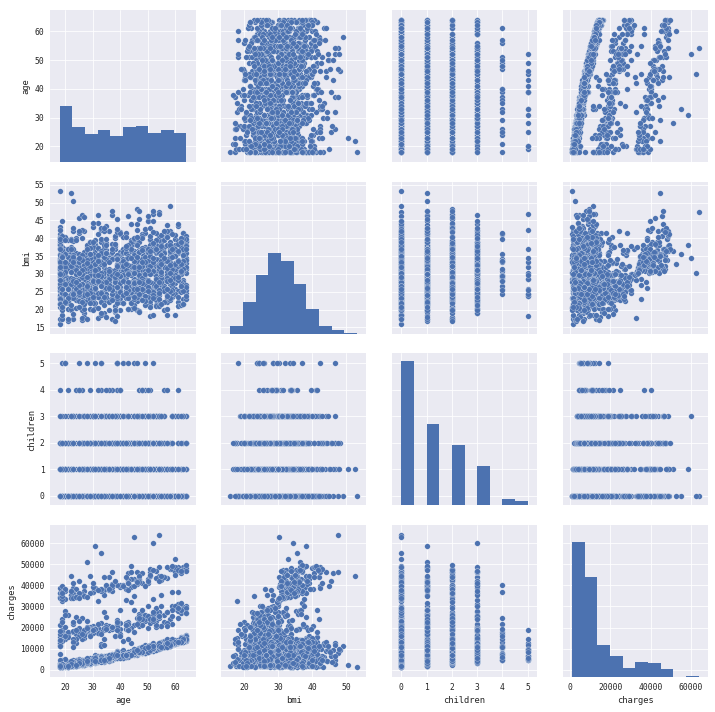

In [9]:
sns.pairplot(df)

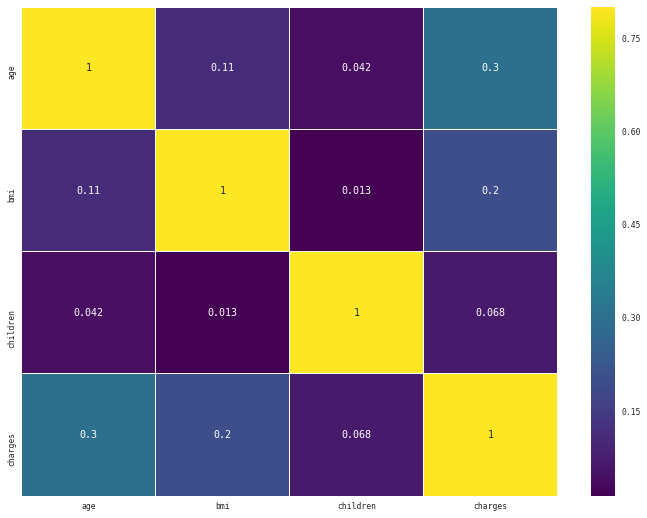

In [10]:
#Heat Map to see the correlation between diffrent variables
#Find the correlation between the different varaibles in the datasets
cormat = df.corr()

#Set uo the matplolib figure
f, ax = plt.subplots(figsize=(12, 9))

#Draw the heatmap using seaborn
colormap = plt.cm.viridis
sns.heatmap(cormat, linewidths=0.1, cmap = colormap, 
            linecolor = 'White', vmax=0.8, annot=True)
plt.show()

In [25]:
df = pd.get_dummies(df)
df.head()

,age,bmi,children,charges,sex_female,sex_male,smoker_no,smoker_yes,region_northeast,region_northwest,region_southeast,region_southwest
0,19,27.900,0,16884.92400,1,0,0,1,0,0,0,1
1,18,33.770,1,1725.55230,0,1,1,0,0,0,1,0
2,28,33.000,3,4449.46200,0,1,1,0,0,0,1,0
3,33,22.705,0,21984.47061,0,1,1,0,0,1,0,0
4,32,28.880,0,3866.85520,0,1,1,0,0,1,0,0


In [31]:
from sklearn.ensemble import RandomForestClassifier

X = df.drop('charges', axis = 1).values
y = df['charges'].astype('int')
names = ['age', 'bmi', 'children', 'sex_female', 'sex_male', 'smoker_no',
       'smoker_yes', 'region_northeast', 'region_northwest',
       'region_southeast', 'region_southwest']
clf = RandomForestClassifier()
clf.fit(X, y)

print("Features sorted by their score:")
print(sorted(zip(map(lambda x: round(x, 4), clf.feature_importances_), names), 
             reverse=True))

Features sorted by their score:
[(0.4245, 'bmi'), (0.3403, 'age'), (0.1185, 'children'), (0.0161, 'region_northwest'), (0.0155, 'sex_male'), (0.0155, 'region_southeast'), (0.0153, 'smoker_no'), (0.0148, 'smoker_yes'), (0.0147, 'sex_female'), (0.0139, 'region_southwest'), (0.0112, 'region_northeast')]


In [32]:
X = df.drop('charges', axis = 1).values
y = df['charges'].values

In [34]:
print(X[:, 1])

[27.9  33.77 33.   ... 36.85 25.8  29.07]


In [35]:
X_bmi = X[:, 1]
print(type(X_bmi))
print(type(y))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [36]:
X_bmi = X_bmi.reshape(-1, 1)
y = y.reshape(-1, 1)

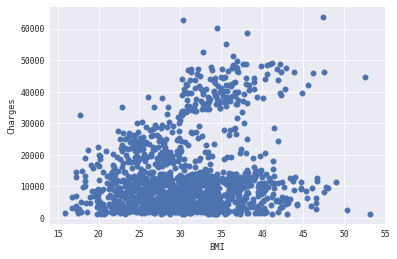

In [37]:
plt.scatter(X_bmi, y)
plt.ylabel("Charges")
plt.xlabel("BMI")
plt.show()

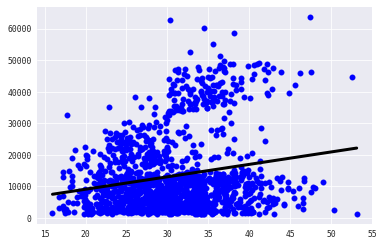

In [38]:
import numpy as np
from sklearn import linear_model
reg = linear_model.LinearRegression()
reg.fit(X_bmi, y)
prediction_space = np.linspace(min(X_bmi), max(X_bmi)).reshape(-1, 1)
plt.scatter(X_bmi, y, color = "blue")
plt.plot(prediction_space ,reg.predict(prediction_space), color = "black", 
         linewidth=3)
plt.show()

In [39]:
## BMI
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_bmi, y, test_size = 0.3, 
                                                   random_state = 42)
reg.fit(X_train, y_train)
reg.score(X_test, y_test)

0.041903708799616586

In [40]:
## BMI + AGE
X_bmi_age = df[['bmi','age']]
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_bmi_age, y, test_size = 0.3, 
                                                   random_state = 42)
reg.fit(X_train, y_train)
reg.score(X_test, y_test)

0.13135244833400728

In [41]:
## Bmi + Age + Children
X_bmi_age_child = df[['bmi', 'age', 'children']]
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_bmi_age_child, y, test_size = 0.3, 
                                                   random_state = 42)
reg.fit(X_train, y_train)
reg.score(X_test, y_test)

0.13111524136803365

In [42]:
# Bmi + Age + Smoke
X_bmi_age_child = df[['bmi', 'age', 'smoker_no','smoker_yes']]
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_bmi_age_child, y, test_size = 0.3, 
                                                   random_state = 42)
reg.fit(X_train, y_train)
reg.score(X_test, y_test)

0.7655078324224212

In [43]:
# All the features
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, 
                                                   random_state = 42)
reg = linear_model.LinearRegression()
reg.fit(X_train, y_train)
reg.score(X_test, y_test)

0.7696118054369012

In [23]:
def linear_regression(X, y, m_current=0, b_current=0, epochs=1000, learning_rate=0.0001):
    N = float(len(y))
    for i in range(epochs):
        y_current = (m_current * X) + b_current
        cost = sum([data**2 for data in (y-y_current)]) / N
        m_gradient = -(2/N) * sum(X * (y - y_current))
        b_gradient = -(2/N) * sum(y - y_current)
        m_current = m_current - (learning_rate * m_gradient)
        b_current = b_current - (learning_rate * b_gradient)
    return m_current, b_current, cost

In [24]:
linear_regression(X_bmi, y)

(array([2198.24593025]), array([2153.69076933]), array([2.2511194e+08]))